# 0. Prepare Environment

## 0.1 General Imports and Reading FCS File

In [1]:
import scanpy as sc
import pytometry as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from joblib import Parallel, delayed

In [2]:
fpath = os.path.join(os.getcwd(), 'data', 'new_sample_10.fcs')

In [3]:
adata = pm.io.read_fcs(fpath)

In [4]:
sc.pp.subsample(adata, 0.1)

In [5]:
adata

AnnData object with n_obs × n_vars = 10834 × 36
    var: 'Channel Number', 'marker', '$PnD', '$PnB', '$PnR', 'channel', '$PnG', '$PnE'
    uns: 'meta'

In [6]:
sc.pp.neighbors(adata)

## 0.2 Pytometry Related Imports

In [7]:
from scipy.stats import entropy
from scipy.special import softmax
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import vstack, hstack
from scanpy.tools._umap import umap
import joblib
from typing import Union, Optional, Literal
_InitPos = Literal['paga', 'spectral', 'random']
AnyRandom = Union[None, int, np.random.RandomState]
HELPER_VAR = {}

# 1. Define Scale Class

In [8]:
class _Scale:
    def __init__(self, X=None, T=None, I=None, W=None, P=None, X_humap=None, lm_ind=None, parent_scale=None):
        self.X = X
        self.T = T
        self.I = I
        self.W = W
        self.P = P
        self.X_humap = X_humap
        self.lm_ind = lm_ind
        self.parent_scale = parent_scale

Declaring and Checking Arguments

In [9]:
imp_channel_ind=None
beta=100
beta_thresh=1.5
teta=50
num_scales=1
min_dist= 0.5
spread= 1.0
n_components= 2
maxiter= None
alpha= 1.0
gamma= 1.0
negative_sample_rate= 5
init_pos='spectral'
random_state= 0
a= None
b= None
copy= False
method= 'umap'
neighbors_key= None

if imp_channel_ind is None:
    imp_channel_ind = range(len(adata.var_names))
elif len(imp_channel_ind) == 0:
    imp_channel_ind = range(len(adata.var_names))

# settings dict for all important setting variables
parameters = {
    'beta': beta,
    'beta_thresh': beta_thresh,
    'teta': teta,
    'imp_channel_ind' : imp_channel_ind}

try:
    adata.obsp['distances']
except KeyError as e:
    raise Exception("k-nearest-neighbor graph has to be constructed first")
distances_nn = adata.obsp['distances']

scale_list = list()

In [10]:
adata.uns['humap_settings'] = parameters
adata.uns['humap_scales'] = scale_list

In [11]:
adata

AnnData object with n_obs × n_vars = 10834 × 36
    var: 'Channel Number', 'marker', '$PnD', '$PnB', '$PnR', 'channel', '$PnG', '$PnE'
    uns: 'meta', 'neighbors', 'humap_settings', 'humap_scales'
    obsp: 'distances', 'connectivities'

# 2. Define Helpers Functions

In [12]:
def _helper_method_calc_T(dist):
    from scipy.special import softmax
    d = dist / np.max(dist)
    return softmax((-d ** 2) / _binary_search_sigma(d, len(d)))

def _binary_search_sigma(d, n_neigh):
    # binary search
    import numpy as np
    sigma = 10  # Start Sigma
    goal = np.log(n_neigh)  # log(k) with k being n_neighbors
    # Do binary search until entropy ~== log(k)
    while True:
        ent = entropy(softmax((-d ** 2) / sigma))
        # check sigma
        if np.isclose(ent, goal):
            return sigma
        if ent > goal:
            sigma *= 0.5
        else:
            sigma /= 0.5

def _helper_method_AoI(state):
    # load globals
    T = HELPER_VAR['T']
    lm = HELPER_VAR['lm']
    reached_lm = np.zeros(len(lm))

    cache = list()  # create empty cache list
    cache.append(state)  # append initial state vector as first element
    state_len = np.shape(state)[1]  # get length of vector once

    # do until minimal landmark-"hit"-count is reached (--> landmarks_left < 0)
    landmarks_left = HELPER_VAR['min_lm']
    while landmarks_left >= 0:
        # erg_random_walk = -1
        step = 1
        while True:
            if len(cache) <= step:
                cache.append(cache[step - 1] * T)
            erg_random_walk = np.random.choice(state_len, p=cache[step].toarray()[0])
            if erg_random_walk in lm:
                reached_lm[lm.index(erg_random_walk)] += 1
                landmarks_left -= 1
                break
            step += 1
    erg = reached_lm / np.sum(reached_lm.data)
    return csr_matrix(erg)

def _helper_method_T_next_mul_W(i):
    # load globals
    W = HELPER_VAR['W']
    num_lm_s_prev = HELPER_VAR['num_lm_s_prev']
    return csr_matrix(np.reshape(i.toarray().reshape((num_lm_s_prev,)) * W, (num_lm_s_prev, 1)))

def _helper_method_T_next_row_div(r):
    return r[1] / np.sum(r[1])

def _helper_method_get_landmarks(state):
    for i in range(HELPER_VAR['teta']):
        state *= HELPER_VAR['T']
    destinations = np.random.choice(range(HELPER_VAR['n_events']), HELPER_VAR['beta'], p=state.toarray()[0])
    hits = np.zeros((HELPER_VAR['n_events']))
    for d in destinations:
        hits[d] += 1
    return [(h[0], h[1]) for h in enumerate(hits) if h[1] > 0]

# 3. Begin Computations

## 3.1 Root (First) Scale

In [13]:
dim = distances_nn.shape[0]
settings = parameters

In [14]:
# Create first scale
s_root = _Scale(X=adata.X[:,imp_channel_ind], W=1)

### 3.1.1 Calculate First Transition Matrix

In [15]:
%%time
probs = map(_helper_method_calc_T, [dist.data for dist in distances_nn])
data = []
for pr in probs:
    data.extend(pr)
T = csr_matrix((data, distances_nn.indices, distances_nn.indptr), shape=(dim,dim))
s_root.T = T

CPU times: total: 2.67 s
Wall time: 2.65 s


### 3.1.2 Calculate P (Symmetrization)

t-SNE Symmetrization   
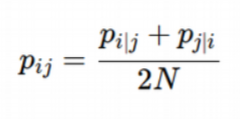

In [16]:
%%time
P = (T + T.transpose()) / (2 * T.shape[0])
s_root.P = P

CPU times: total: 0 ns
Wall time: 10 ms


Umap Symmetrization  
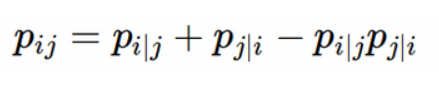

In [17]:
%%time
P = T + T.transpose() - T.multiply(T.transpose())
s_root.P = P

CPU times: total: 15.6 ms
Wall time: 15 ms


### 3.1.3 Create a temporary adata and embed root scale with UMAP

In [18]:
tmpdata = sc.AnnData(s_root.X)
tmpdata.obsp['connectivities'] = s_root.P
tmpdata.obsm['X_pca'] = s_root.X
tmpdata.uns['neighbors'] = {
    'params':{'method':'umap'},
    'connectivities_key':'connectivities'
}

In [19]:
%%time
umap(
    tmpdata,
    min_dist=min_dist,
    spread=spread,
    n_components=n_components,
    maxiter=maxiter,
    alpha=alpha,
    gamma=gamma,
    negative_sample_rate=negative_sample_rate,
    init_pos=init_pos,
    random_state=random_state,
    a=a,
    b=b,
    copy=False,
    method=method,
    neighbors_key=neighbors_key)
X_humap = tmpdata.obsm['X_umap'].copy()
s_root.X_humap = X_humap

CPU times: total: 17.5 s
Wall time: 17 s


### 3.1.4 Get landmarks to build the next scale on top of it

In [20]:
n_events = T.shape[0]
proposals = np.zeros(n_events)  # counts how many times point has been reached
landmarks = list()  # list of landmarks
HELPER_VAR = {'T': T,
              'teta': settings['teta'],
              'beta': settings['beta'],
              'beta_thresh': settings['beta_thresh'],
              'n_events': n_events}

#### 3.1.4.1 Get Hit List

**I have removed multiprocessing because it gives error on jupyter notebook**  
[Reported issue](https://github.com/ipython/ipython/issues/12396)

In [21]:
%%time
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])

CPU times: total: 359 ms
Wall time: 353 ms


#### 3.1.4.2 Evaluate results

Below cell is a bottleneck. It uses non-parallel nested for loops whose computational complexity is O(n**2)

In [22]:
%%time
# evaluate results
for state_hits in hit_list:
    for h in state_hits:
        proposals[h[0]] += h[1]

CPU times: total: 8min 33s
Wall time: 8min 36s


**Alternative Implementation #1**  
Parallel for loop (Don't result in speed improvement)

In [23]:
# Get hit list again
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])

In [24]:
def _helper_func(state_hits):
    for h in state_hits:
        proposals[h[0]] += h[1]

In [ ]:
%%time
_ = Parallel(n_jobs=8)(delayed(_helper_func)(state_hits) for state_hits in hit_list)

**Alternative Implementation #2**  
Map (Don't result in speed improvement)

In [26]:
# Get hit list again
proposals = np.zeros(n_events)
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])

In [27]:
def temp_func(state_hits):
    for h in state_hits:
        proposals[h[0]] += h[1]

In [28]:
%%time
map(temp_func, [state_hits for state_hits in hit_list])

CPU times: total: 7min 12s
Wall time: 7min 17s


#### 3.1.4.3 Collect landmarks

In [23]:
%%time
min_beta = settings['beta'] * settings['beta_thresh']
for prop in enumerate(proposals):
    # if event has been hit min_beta times, it counts as landmark
    if prop[1] > min_beta:
        landmarks.append(prop[0])

CPU times: total: 0 ns
Wall time: 2 ms


In [24]:
# Store scale information in the list
s_root.lm_ind = landmarks
scale_list.append(s_root)

# 3.2 Second Scale

In [25]:
s_prev = scale_list[0]

In [26]:
s_curr = _Scale(X=s_prev.X[s_prev.lm_ind, :], parent_scale=s_prev)

In [27]:
%%time
scale = s_prev
min_lm = 100

n_events = scale.T.shape[0]
# create state matrix containing all initial states
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))

HELPER_VAR = {'lm': scale.lm_ind, 'min_lm': min_lm, 'T': scale.T}
I = map(_helper_method_AoI, [s for s in init_states])
I = vstack(I)
s_curr.I = I

CPU times: total: 15min 46s
Wall time: 15min 47s


In [28]:
%%time
I = s_curr.I
W_old = s_prev.W
if type(W_old) is int: #W_old is None or W_old is 1:
    W_old = np.ones((I.shape[0],))
W_s = np.array(W_old * I).reshape((I.shape[1]))
s_curr.W = W_s

CPU times: total: 0 ns
Wall time: 2.96 ms


In [29]:
%%time
I = s_curr.I
W = s_prev.W

num_lm_s_prev, num_lm_s = (I.shape[0],I.shape[1])  # dimensionst of I
# num_lm_s_old > num_lm_s
I_t = I.transpose()  # transposed Influence matrix

HELPER_VAR = {'W': W, 'num_lm_s_prev': num_lm_s_prev}

I_with_W = map(_helper_method_T_next_mul_W, [it for it in I_t])
I_with_W = hstack(list(I_with_W))
I = I_with_W.T * I
T_next = map(_helper_method_T_next_row_div, enumerate(I))

T_next = vstack(T_next)
T_next = T_next.tocsr()
s_curr.T = T_next

CPU times: total: 1.62 s
Wall time: 1.64 s


In [30]:
%%time
T = s_curr.T
settings = parameters
n_events = T.shape[0]
proposals = np.zeros(n_events)  # counts how many times point has been reached
landmarks = list()  # list of landmarks

HELPER_VAR = {'T': T, 'teta': settings['teta'], 'beta': settings['beta'], 
              'beta_thresh': settings['beta_thresh'], 'n_events': n_events}
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])
# evaluate results
for state_hits in hit_list:  # for every states hit_list
    for h in state_hits:  # for every hit in some states hit_list
        proposals[h[0]] += h[1]
# collect landmarks
min_beta = settings['beta'] * settings['beta_thresh']
for prop in enumerate(proposals):
    # if event has been hit min_beta times, it counts as landmark
    if prop[1] > min_beta:
        landmarks.append(prop[0])
s_curr.lm_ind = landmarks

CPU times: total: 4min 29s
Wall time: 4min 29s


t-SNE Symmetrization

In [31]:
%%time
T = s_curr.T
P = (T + T.transpose()) / (2 * T.shape[0])
s_curr.P = P

CPU times: total: 46.9 ms
Wall time: 46.4 ms


Umap Symmetrization

In [32]:
%%time
T = s_curr.T
P = T + T.transpose() - T.multiply(T.transpose())
s_curr.P = P

CPU times: total: 78.1 ms
Wall time: 77.8 ms


Create a temporary anndata to be compatible with scanpy's umap

In [33]:
tmpdata = sc.AnnData(X=s_curr.X)
tmpdata.obsp['connectivities'] = s_curr.P
tmpdata.obsm['X_pca'] = s_curr.X
tmpdata.uns['neighbors'] = {'params':{'method':'umap'}}
tmpdata.uns['neighbors']['connectivities_key'] = 'connectivities'

In [34]:
%%time
umap(
     tmpdata,
     min_dist=min_dist,
     spread=spread,
     n_components=n_components,
     maxiter=maxiter,
     alpha=alpha,
     gamma=gamma,
     negative_sample_rate=negative_sample_rate,
     init_pos=init_pos,
     random_state=random_state,
     a=a,
     b=b,
     copy=False,
     method=method,
     neighbors_key=neighbors_key)
X_humap = tmpdata.obsm['X_umap']
s_curr.X_humap = X_humap

CPU times: total: 3.72 s
Wall time: 3.77 s


In [35]:
scale_list.append(s_curr)

## 3.3 Third Scale

In [36]:
s_prev = scale_list[1]
s_curr = _Scale(X=s_prev.X[s_prev.lm_ind, :], parent_scale=s_prev)

In [37]:
%%time
scale = s_prev
min_lm = 100

n_events = scale.T.shape[0]
# create state matrix containing all initial states
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
HELPER_VAR = {'lm': scale.lm_ind, 'min_lm': min_lm, 'T': scale.T}
I = map(_helper_method_AoI, [s for s in init_states])
I = vstack(I)
s_curr.I = I

CPU times: total: 1min 57s
Wall time: 1min 57s


In [38]:
%%time
I = s_curr.I
W_old = s_prev.W
if type(W_old) is int: #W_old is None or W_old is 1:
    W_old = np.ones((I.shape[0],))
W_s = np.array(W_old * I).reshape((I.shape[1]))
s_curr.W = W_s

CPU times: total: 0 ns
Wall time: 231 µs


In [39]:
%%time
I = s_curr.I
W = s_prev.W

num_lm_s_prev, num_lm_s = (I.shape[0],I.shape[1])  # dimensionst of I
# num_lm_s_old > num_lm_s
I_t = I.transpose()  # transposed Influence matrix

HELPER_VAR = {'W': W, 'num_lm_s_prev': num_lm_s_prev}

I_with_W = map(_helper_method_T_next_mul_W, [it for it in I_t])
I_with_W = hstack(list(I_with_W))
I = I_with_W.T * I
T_next = map(_helper_method_T_next_row_div, enumerate(I))

T_next = vstack(T_next)
T_next = T_next.tocsr()
s_curr.T = T_next

CPU times: total: 141 ms
Wall time: 143 ms


In [40]:
%%time
T = s_curr.T
settings = parameters
n_events = T.shape[0]
proposals = np.zeros(n_events)  # counts how many times point has been reached
landmarks = list()  # list of landmarks
global HELPER_VAR
HELPER_VAR = {'T': T, 'teta': settings['teta'], 'beta': settings['beta'], 
              'beta_thresh': settings['beta_thresh'], 'n_events': n_events}
init_states = csr_matrix((np.ones(n_events), (range(n_events), range(n_events))))
hit_list = map(_helper_method_get_landmarks, [state for state in init_states])
# evaluate results
for state_hits in hit_list:  # for every states hit_list
    for h in state_hits:  # for every hit in some states hit_list
        proposals[h[0]] += h[1]
# collect landmarks
min_beta = settings['beta'] * settings['beta_thresh']
for prop in enumerate(proposals):
    # if event has been hit min_beta times, it counts as landmark
    if prop[1] > min_beta:
        landmarks.append(prop[0])
s_curr.lm_ind = landmarks

CPU times: total: 3.23 s
Wall time: 3.23 s


In [41]:
%%time
T = s_curr.T
P = (T + T.transpose()) / (2 * T.shape[0])
s_curr.P = P

CPU times: total: 0 ns
Wall time: 3 ms


In [42]:
tmpdata = sc.AnnData(X=s_curr.X)
tmpdata.obsp['connectivities'] = s_curr.P
tmpdata.obsm['X_pca'] = s_curr.X
tmpdata.uns['neighbors'] = {'params':{'method':'umap'}}
tmpdata.uns['neighbors']['connectivities_key'] = 'connectivities'

In [43]:
%%time
umap(
     tmpdata,
     min_dist=min_dist,
     spread=spread,
     n_components=n_components,
     maxiter=maxiter,
     alpha=alpha,
     gamma=gamma,
     negative_sample_rate=negative_sample_rate,
     init_pos=init_pos,
     random_state=random_state,
     a=a,
     b=b,
     copy=False,
     method=method,
     neighbors_key=neighbors_key)
X_humap = tmpdata.obsm['X_umap']
s_curr.X_humap = X_humap

CPU times: total: 1.27 s
Wall time: 1.34 s


In [44]:
scale_list.append(s_curr)

# 4. Plot Embeddings for Each Level

In [45]:
l1 = scale_list[0].X_humap
l2 = scale_list[1].X_humap
l3 = scale_list[2].X_humap

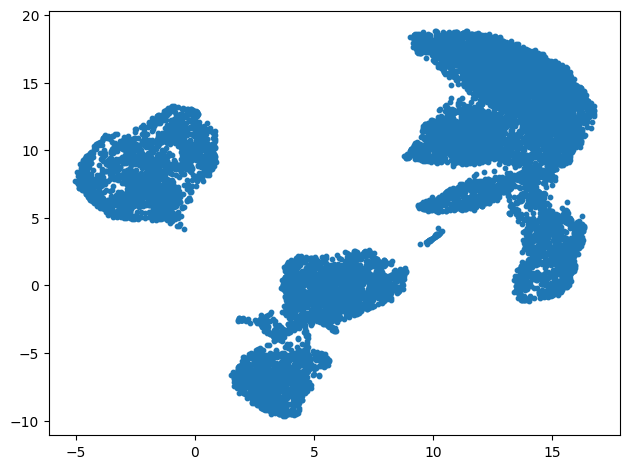

In [51]:
plt.scatter(l1[:,0], l1[:,1], s=10)
plt.tight_layout()

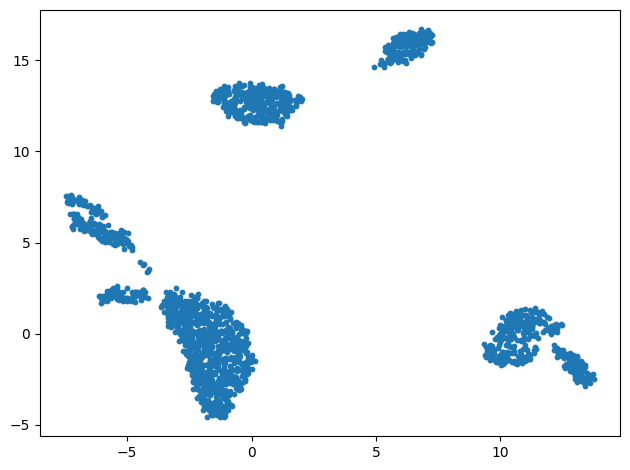

In [52]:
plt.scatter(l2[:,0], l2[:,1], s=10)
plt.tight_layout()

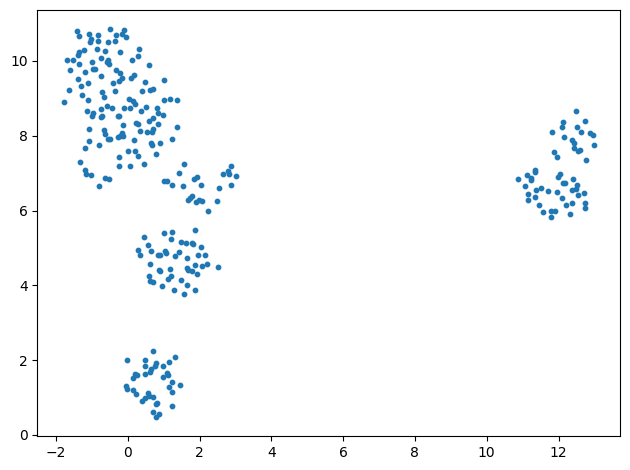

In [53]:
plt.scatter(l3[:,0], l3[:,1], s=10)
plt.tight_layout()